In [177]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cftime
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import string
alphabet=list(string.ascii_lowercase)

import warnings
warnings.filterwarnings('ignore')

seconds_per_day=60.*60.*24.
seconds_per_year=365.*seconds_per_day
carbon_molar_mass=12.011
cobalt_n_2_c = 106./16.

In [178]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Read in Data

In [179]:
ctrl={}
case={}

ctrl['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT'
ctrl['machine_target']='gfdl.ncrc4-intel19-prod'
ctrl['name']='OM4p5_CORE2_IAF_gzCOBALT-013022_cy5'

case['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_gzCOBALTv2'
case['machine_target']='gfdl.ncrc4-intel19-prod'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_cy5'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_hp_cy5'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-hp_cy5'

#case=ctrl

In [180]:
short_casename=case['name'].replace('OM4p5_CORE2_IAF_','')
if short_casename=="gzCOBALT-060822":
    fig_casename='gzCOBALT-tun_cy1'
else:
    fig_casename=short_casename
print(short_casename, fig_casename)

gzCOBALT-hp_cy5 gzCOBALT-hp_cy5


In [181]:
tmpdir = '/work/Jessica.Luo/tmp/'+case['name']
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-hp_cy5


In [182]:
# read in files
diagTypes = ['ocean_cobalt_omip_tracers_year_z'] 

pp_dates='1988-2007'

files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

files=sorted([f for fi in files for f in fi]) # nested list comprehension


In [183]:
if not files:
    pp_path=os.path.join(case['path_root'], case['name'], case['machine_target'], 'pp')
    
    files=[glob(pp_path + '/' + d + '/av/annual_5yr/' + d + '.' + pp_dates + '*.nc') for d in diagTypes]
    
    files=sorted([f for fi in files for f in fi]) # nested list comprehension
print(files)


['/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-hp_cy5/ocean_cobalt_omip_tracers_year_z.1988-2007.nc']


In [184]:
grid_file=os.path.join(case['path_root'], case['name'], case['machine_target'], 'pp')+'/ocean_annual/ocean_annual.static.nc'
ds=xr.open_mfdataset(files, combine='by_coords')
grid=xr.open_dataset(grid_file)

In [185]:
tmpdir = '/work/Jessica.Luo/tmp/'+ctrl['name']
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)
    
# read in files
diagTypes = ['ocean_cobalt_omip_tracers_year_z'] 

pp_dates='1988-2007'

c_files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

c_files=sorted([f for fi in c_files for f in fi]) # nested list comprehension
print(c_files)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-013022_cy5
['/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-013022_cy5/ocean_cobalt_omip_tracers_year_z.1988-2007.nc']


In [186]:
dc=xr.open_mfdataset(c_files, combine='by_coords')

In [187]:
ds['depth_levels']=xr.DataArray(ds.z_i.diff(dim='z_i').values, coords={'z_l':ds.z_l.values}, dims=['z_l'], attrs={'long_name':'Thickness of depth bin', 'units':'meters'})

## Read in Observations

In [188]:
o2_obs = xr.open_dataset('/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/O2_woa18_esm4grid.nc')
no3_obs = xr.open_dataset('/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/nitrate_woa18_esm4grid.nc') # micromoles per kilogram, or micromol/L, equivalent to 1e-3 mol m-3
po4_obs = xr.open_dataset('/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/phosphate_woa18_esm4grid.nc')
sio3_obs = xr.open_dataset('/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/silicate_woa18_esm4grid.nc')
fe_obs = xr.open_dataset('/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/iron_esm4grid.nc')

## Change Units on Model Data

In [189]:
ds = ds.isel(time=0)
o2_mod = ds.o2 * 1e3    # convert to mmoles m-3
no3_mod = ds.no3 * 1e3  # convert to mmoles m-3
po4_mod = ds.po4 * 1e3  # convert to mmoles m-3
sio4_mod = ds.si * 1e3  # convert to mmoles m-3
dfe_mod = ds.dfe * 1e6  # convert to micromoles m-3

# Transects

## Read in Cross Section

In [190]:
xs = xr.open_dataset('/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/CrossSections_transect_data_refined2.nc')

In [191]:
xs

<xarray.Dataset>
Dimensions:         (index: 993)
Coordinates:
  * index           (index) int64 0 1 2 3 4 5 6 ... 986 987 988 989 990 991 992
Data variables:
    lat_transects   (index) float64 ...
    lon_transects   (index) float64 ...
    i_ind_trans     (index) uint16 ...
    j_ind_trans     (index) uint16 ...
    ind_transects   (index) int32 ...
    orientation     (index) uint8 ...
    dist_transects  (index) float64 ...

## Extract Model

In [192]:
# Number of grid cells on each side of the transect line for averaging
# iron observations only
width = 5

In [193]:
# Calculate N*
N_star_mod = no3_mod - 16.0*po4_mod

In [194]:
o2_mod_trans = o2_mod.values[:,xs.j_ind_trans.values,xs.i_ind_trans.values]
no3_mod_trans = no3_mod.values[:,xs.j_ind_trans.values,xs.i_ind_trans.values]
po4_mod_trans = po4_mod.values[:,xs.j_ind_trans.values,xs.i_ind_trans.values]
sio4_mod_trans = sio4_mod.values[:,xs.j_ind_trans.values,xs.i_ind_trans.values]
dfe_mod_trans = dfe_mod.values[:,xs.j_ind_trans.values,xs.i_ind_trans.values]
N_star_mod_trans = N_star_mod.values[:,xs.j_ind_trans.values,xs.i_ind_trans.values]

## Extract Observations

In [195]:
# Calculate N*
N_star_obs = no3_obs['nitrate_woa18'] - 16.0*po4_obs['phosphate_woa18']

In [196]:
o2_obs_trans = o2_obs['O2_woa18'].values[:,xs.j_ind_trans.values,xs.i_ind_trans.values]
no3_obs_trans = no3_obs['nitrate_woa18'].values[:,xs.j_ind_trans.values,xs.i_ind_trans.values]
po4_obs_trans = po4_obs['phosphate_woa18'].values[:,xs.j_ind_trans.values,xs.i_ind_trans.values]
sio3_obs_trans = sio3_obs['silicate_woa18'].values[:,xs.j_ind_trans.values,xs.i_ind_trans.values]
fe_obs_trans = fe_obs['iron'].values[:,xs.j_ind_trans.values,xs.i_ind_trans.values]
N_star_obs_trans = N_star_obs.values[:,xs.j_ind_trans.values,xs.i_ind_trans.values]

# Evaluate Skill Metrics

In [197]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmse_diffs(differences):
    return np.sqrt(np.sum((differences ** 2)/len(differences)))

In [198]:
def log_differences(ds1, ds2, minimum=0.1):
    if(len(ds1) != len(ds2)):
        print('ERROR: Arrays are not the same length')
        return NULL
    array_length=len(ds1)
    min_array = np.repeat(minimum,array_length)
    
    log_ds1 = np.log10(np.maximum(ds1, min_array))
    log_ds2 = np.log10(np.maximum(ds2, min_array))
    
    return log_ds1 - log_ds2

In [199]:
# Oxygen
X=o2_mod_trans.flatten()
Y=o2_obs_trans.flatten()
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_o2 = X[mask] - Y[mask]
res2_o2 = log_differences(X[mask],Y[mask],minimum=0.)
skew1_o2 = stats.skew(res1_o2)
skew2_o2 = stats.skew(res2_o2)
res_o2 = res1_o2
r_o2 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_o2 = rmse_diffs(res_o2)
bias_o2 = np.mean(res_o2)

In [200]:
# Nitrate
X=no3_mod_trans.flatten()
Y=no3_obs_trans.flatten()
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_no3 = X[mask] - Y[mask]
res2_no3 = log_differences(X[mask],Y[mask],minimum=0.)
skew1_no3 = stats.skew(res1_no3)
skew2_no3 = stats.skew(res2_no3)
res_no3 = res1_no3
r_no3 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_no3 = rmse_diffs(res_no3)
bias_no3 = np.mean(res_no3)

In [201]:
# Phosphate
X=po4_mod_trans.flatten()
Y=po4_obs_trans.flatten()
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_po4 = X[mask] - Y[mask]
res2_po4 = log_differences(X[mask],Y[mask],minimum=0.)
skew1_po4 = stats.skew(res1_po4)
skew2_po4 = stats.skew(res2_po4)
res_po4 = res1_po4
r_po4 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_po4 = rmse_diffs(res_po4)
bias_po4 = np.mean(res_po4)

In [202]:
# Silicate
X=sio4_mod_trans.flatten()
Y=sio3_obs_trans.flatten()
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_sio4 = X[mask] - Y[mask]
res2_sio4 = log_differences(X[mask],Y[mask],minimum=0.)
skew1_sio4 = stats.skew(res1_sio4)
skew2_sio4 = stats.skew(res2_sio4)
res_sio4 = res1_sio4
r_sio4 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_sio4 = rmse_diffs(res_sio4)
bias_sio4 = np.mean(res_sio4)

In [203]:
# N*
X=N_star_mod_trans.flatten()
Y=N_star_obs_trans.flatten()
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_N_star = X[mask] - Y[mask]
res2_N_star = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_N_star = stats.skew(res1_N_star)
skew2_N_star = stats.skew(res2_N_star)
res_N_star = res1_N_star
r_N_star = stats.pearsonr(X[mask],Y[mask])[0]
rmse_N_star = rmse_diffs(res_N_star)
bias_N_star = np.mean(res_N_star)

In [204]:
## IRON
## TO-DO

# Plot

In [205]:
print(ds.z_l.isel(z_l=slice(None,19)))
ds.z_l.values[19:35]

<xarray.DataArray 'z_l' (z_l: 19)>
array([   2.5 ,   10.  ,   20.  ,   32.5 ,   51.25,   75.  ,  100.  ,  125.  ,
        156.25,  200.  ,  250.  ,  312.5 ,  400.  ,  500.  ,  600.  ,  700.  ,
        800.  ,  900.  , 1000.  ])
Coordinates:
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 51.25 ... 700.0 800.0 900.0 1e+03
    time     object 1998-01-01 00:00:00


array([1100. , 1200. , 1300. , 1400. , 1537.5, 1750. , 2062.5, 2500. ,
       3000. , 3500. , 4000. , 4500. , 5000. , 5500. , 6000. , 6500. ])

In [206]:
ds.z_l.values[[0,5,10,15,20,25,30]]

array([2.5000e+00, 7.5000e+01, 2.5000e+02, 7.0000e+02, 1.2000e+03,
       2.0625e+03, 4.5000e+03])

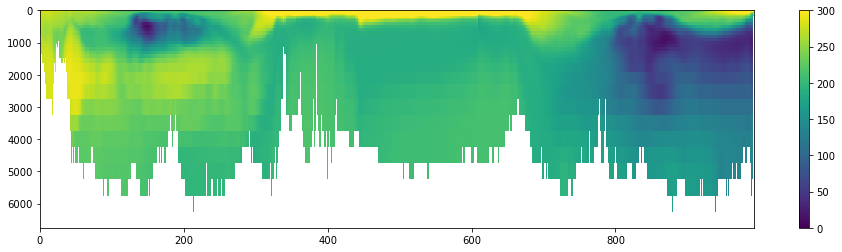

In [207]:
plt.figure(figsize=(16,4))
plt.pcolormesh(xs.index.values, ds.z_l.values, o2_mod_trans,vmax=300,vmin=0)
plt.gca().invert_yaxis()
plt.colorbar()

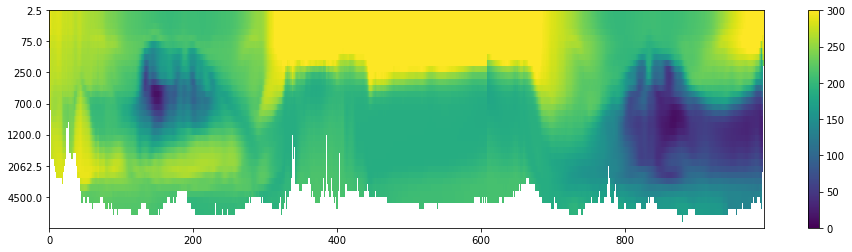

In [208]:
plt.figure(figsize=(16,4))
plt.pcolormesh(o2_mod_trans,vmax=300,vmin=0)
#plt.contourf(o2_mod_trans,levels=15,vmax=300,vmin=0,extend='max')
plt.gca().invert_yaxis()
plt.yticks(ticks=[0,5,10,15,20,25,30],labels=ds.z_l.values[[0,5,10,15,20,25,30]])
plt.colorbar()

In [209]:
xtick_ind = [14, 103, 187, 271, 360, 662, 751, 835, 920, 993];
xtick_labels = ['60N','30N',' 0 ','30S','60S','60S','30S',' 0 ','30N','   ']

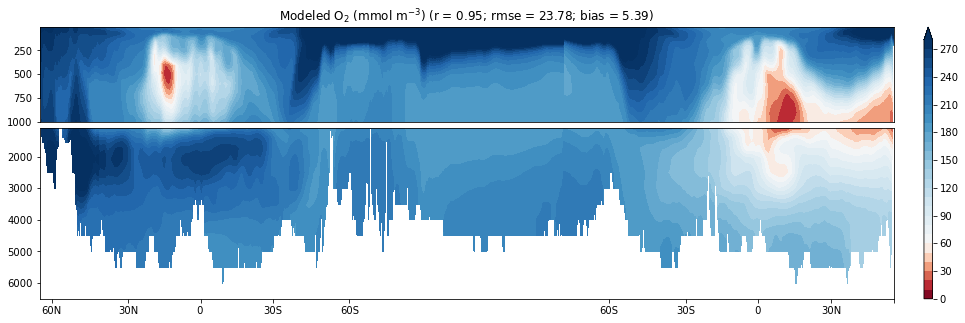

In [210]:
plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.07, height_ratios=(1,1.8), width_ratios=(1,0.01))

cmin=0; cmax=290; cint=10
levels=np.arange(cmin,cmax,cint)

ax = plt.subplot(gs[0,0])
field = o2_mod_trans[0:19,:]
cs=plt.contourf(xs.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=60.), 
                extend='max', levels=levels, cmap='RdBu')
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_title('Modeled O$_2$ (mmol m$^{-3}$) (r = ' + str(np.round(r_o2,2)) + \
                 '; rmse = ' + str(np.round(rmse_o2,2)) + \
                 '; bias = ' + str(np.round(bias_o2,2)) + ')', 
             fontsize=12)

ax = plt.subplot(gs[1,0])
field = o2_mod_trans[19:,:]
cs=plt.contourf(xs.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=60.), 
                extend='max', levels=levels, cmap='RdBu')
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels)

cb = plt.colorbar(cs,
    cax=plt.subplot(gs[:,-1]),
    orientation='vertical')

plt.tight_layout()

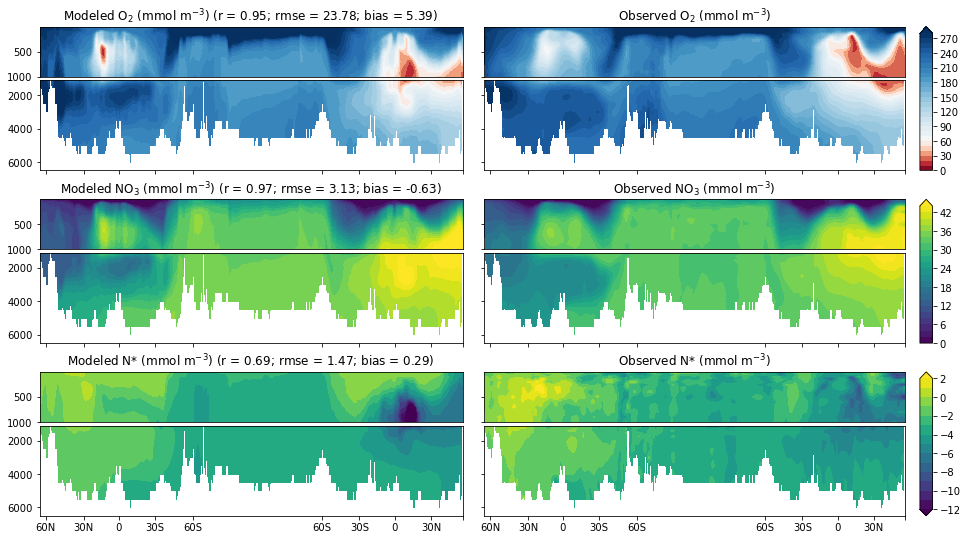

In [211]:
plt.figure(figsize=(16,9))
gs=gridspec.GridSpec(3,2, width_ratios=[1,1.06], wspace=0.05, hspace=0.2)

###########################################################################
# oxygen from model                                                       #
###########################################################################
gs00 = gs[0,0].subgridspec(2,1, hspace=0.05, height_ratios=(1,1.8))

cmin=0; cmax=290; cint=10
levels=np.arange(cmin,cmax,cint)

ax = plt.subplot(gs00[0,0])
field = o2_mod_trans[0:19,:]
cs=plt.contourf(xs.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=60.), 
                extend='max', levels=levels, cmap='RdBu')
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_title('Modeled O$_2$ (mmol m$^{-3}$) (r = ' + str(np.round(r_o2,2)) + \
                 '; rmse = ' + str(np.round(rmse_o2,2)) + \
                 '; bias = ' + str(np.round(bias_o2,2)) + ')', 
             fontsize=12)

ax = plt.subplot(gs00[1,0])
field = o2_mod_trans[19:,:]
cs=plt.contourf(xs.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=60.), 
                extend='max', levels=levels, cmap='RdBu')
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels); ax.set_xticklabels([])

###########################################################################
# oxygen from obs                                                         #
###########################################################################
gs01 = gs[0,1].subgridspec(2,2, hspace=0.05, height_ratios=(1,1.8), wspace=0.07, width_ratios=(1,0.03))

ax = plt.subplot(gs01[0,0])
field = o2_obs_trans[0:19,:]
cs=plt.contourf(xs.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=60.), 
                extend='max', levels=levels, cmap='RdBu')
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Observed O$_2$ (mmol m$^{-3}$)',
             fontsize=12)

ax = plt.subplot(gs01[1,0])
field = o2_obs_trans[19:,:]
cs=plt.contourf(xs.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                norm=MidpointNormalize(midpoint=60.), 
                extend='max', levels=levels, cmap='RdBu')
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels); ax.set_xticklabels([])
ax.set_yticklabels([])

cb = plt.colorbar(cs,
    cax=plt.subplot(gs01[:,-1]),
    orientation='vertical')


###########################################################################
# nitrate from model                                                      #
###########################################################################
gs10 = gs[1,0].subgridspec(2,1, hspace=0.05, height_ratios=(1,1.8))

cmin=0; cmax=45; cint=2
levels=np.arange(cmin,cmax,cint)

ax = plt.subplot(gs10[0,0])
field = no3_mod_trans[0:19,:]
cs=plt.contourf(xs.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                extend='max', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_title('Modeled NO$_3$ (mmol m$^{-3}$) (r = ' + str(np.round(r_no3,2)) + \
                 '; rmse = ' + str(np.round(rmse_no3,2)) + \
                 '; bias = ' + str(np.round(bias_no3,2)) + ')',
             fontsize=12)

ax = plt.subplot(gs10[1,0])
field = no3_mod_trans[19:,:]
cs=plt.contourf(xs.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                extend='max', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels); ax.set_xticklabels([])

###########################################################################
# nitrate from obs                                                        #
###########################################################################
gs11 = gs[1,1].subgridspec(2,2, hspace=0.05, height_ratios=(1,1.8), wspace=0.07, width_ratios=(1,0.03))

ax = plt.subplot(gs11[0,0])
field = no3_obs_trans[0:19,:]
cs=plt.contourf(xs.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                extend='max', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Observed NO$_3$ (mmol m$^{-3}$)',
             fontsize=12)

ax = plt.subplot(gs11[1,0])
field = no3_obs_trans[19:,:]
cs=plt.contourf(xs.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                extend='max', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels); ax.set_xticklabels([])
ax.set_yticklabels([])

cb = plt.colorbar(cs,
    cax=plt.subplot(gs11[:,-1]),
    orientation='vertical')


###########################################################################
# N* from model                                                           #
###########################################################################
gs20 = gs[2,0].subgridspec(2,1, hspace=0.05, height_ratios=(1,1.8))

cmin = -12; cmax = 3; cint = 1
levels=np.arange(cmin,cmax,cint)

ax = plt.subplot(gs20[0,0])
field = N_star_mod_trans[0:19,:]
cs=plt.contourf(xs.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                extend='both', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_title('Modeled N* (mmol m$^{-3}$) (r = ' + str(np.round(r_N_star,2)) + \
                 '; rmse = ' + str(np.round(rmse_N_star,2)) + \
                 '; bias = ' + str(np.round(bias_N_star,2)) + ')',
             fontsize=12)

ax = plt.subplot(gs20[1,0])
field = N_star_mod_trans[19:,:]
cs=plt.contourf(xs.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                extend='both', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels)

###########################################################################
# N* from obs                                                             #
###########################################################################
gs21 = gs[2,1].subgridspec(2,2, hspace=0.05, height_ratios=(1,1.8), wspace=0.07, width_ratios=(1,0.03))

ax = plt.subplot(gs21[0,0])
field = N_star_obs_trans[0:19,:]
cs=plt.contourf(xs.index.values, ds.isel(z_l=slice(None,19)).z_l.values, field, 
                extend='both', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Observed N* (mmol m$^{-3}$)',
             fontsize=12)

ax = plt.subplot(gs21[1,0])
field = N_star_obs_trans[19:,:]
cs=plt.contourf(xs.index.values, ds.isel(z_l=slice(19,None)).z_l.values, field, 
                extend='both', levels=levels)
plt.gca().invert_yaxis()
ax.set_xticks(xtick_ind)
ax.set_xticklabels(xtick_labels)
ax.set_yticklabels([])

cb = plt.colorbar(cs,
    cax=plt.subplot(gs21[:,-1]),
    orientation='vertical')

# plt.figtext(0.05, 0.02,'Atlantic',fontsize=12)
# plt.figtext(0.20, 0.02,'Southern',fontsize=12)
# plt.figtext(0.32, 0.02,'Pacific',fontsize=12)

# plt.figtext(0.48, 0.02,'Atlantic',fontsize=12)
# plt.figtext(0.63, 0.02,'Southern',fontsize=12)
# plt.figtext(0.75, 0.02,'Pacific',fontsize=12)

# plt.tight_layout(rect=(0,.025,1,1))

plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_Nutrient_CrossSection_Split.png', dpi=300, bbox_inches='tight')

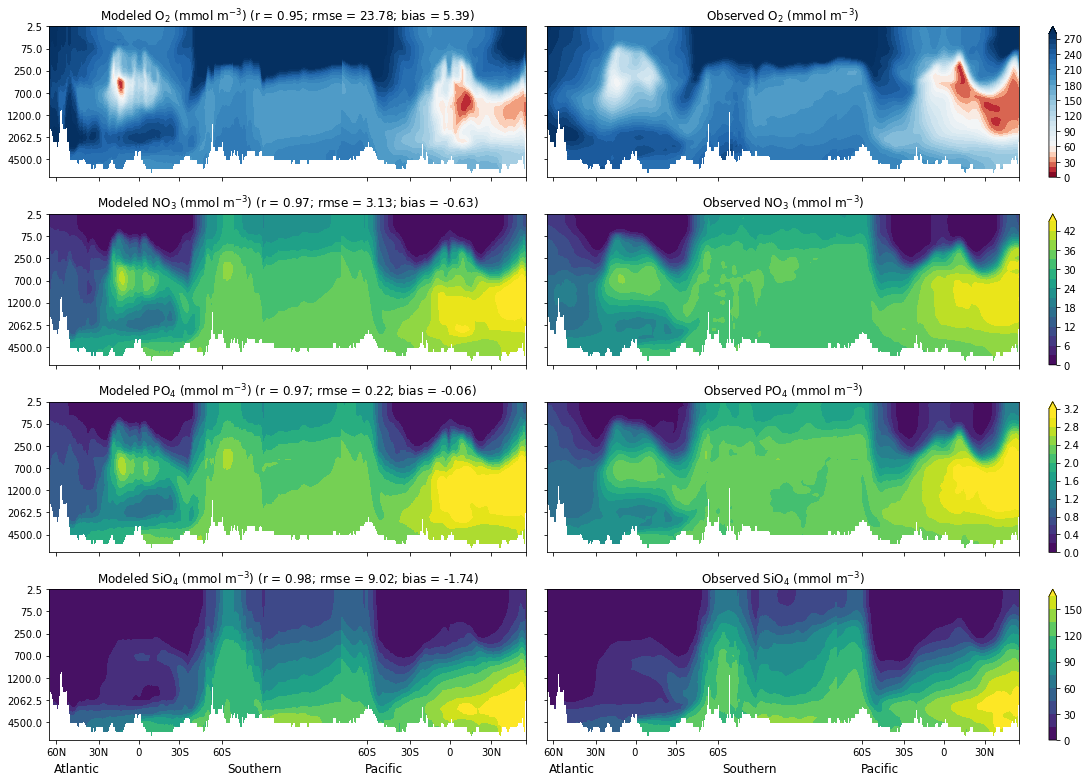

In [212]:
plt.figure(figsize=(16,11))
gs=gridspec.GridSpec(4,2, width_ratios=[1,1.24])

ax={};cs={}

###########################################################################
# oxygen                                                                  #
###########################################################################
cmin=0; cmax=290; cint=10
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0])
#plt.pcolormesh(o2_mod_trans,vmax=300,vmin=0)
cs[i]=plt.contourf(o2_mod_trans,norm=MidpointNormalize(midpoint=60.), extend='max', levels=levels, cmap='RdBu')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels([])
#ax[i].set_xticklabels(xtick_labels)
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels(ds.z_l.values[[0,5,10,15,20,25,30]])
ax[i].set_title('Modeled O$_2$ (mmol m$^{-3}$) (r = ' + str(np.round(r_o2,2)) + \
                 '; rmse = ' + str(np.round(rmse_o2,2)) + \
                 '; bias = ' + str(np.round(bias_o2,2)) + ')')
#cbar=plt.colorbar()

i=1
ax[i]=plt.subplot(gs[0,1])
cs[i]=plt.contourf(o2_obs_trans,norm=MidpointNormalize(midpoint=60.), extend='max', levels=levels, cmap='RdBu')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels([])
#ax[i].set_xticklabels(xtick_labels)
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels([])
#ax[i].set_yticklabels(ds.z_l.values[[0,5,10,15,20,25,30]])
ax[i].set_title('Observed O$_2$ (mmol m$^{-3}$)')
cbar=plt.colorbar()


###########################################################################
# nitrate                                                                 #
###########################################################################
i=2
ax[i]=plt.subplot(gs[1,0])
#plt.pcolormesh(no3_mod_trans,vmax=300,vmin=0)
cs[i]=plt.contourf(no3_mod_trans,levels=15,vmax=45,vmin=0,extend='max')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels([])
#ax[i].set_xticklabels(xtick_labels)
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels(ds.z_l.values[[0,5,10,15,20,25,30]])
ax[i].set_title('Modeled NO$_3$ (mmol m$^{-3}$) (r = ' + str(np.round(r_no3,2)) + \
                 '; rmse = ' + str(np.round(rmse_no3,2)) + \
                 '; bias = ' + str(np.round(bias_no3,2)) + ')')

i=3
ax[i]=plt.subplot(gs[1,1])
cs[i]=plt.contourf(no3_obs_trans,levels=15,vmax=45,vmin=0,extend='max')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels([])
#ax[i].set_xticklabels(xtick_labels)
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels([])
#ax[i].set_yticklabels(ds.z_l.values[[0,5,10,15,20,25,30]])
ax[i].set_title('Observed NO$_3$ (mmol m$^{-3}$)')
cbar=plt.colorbar()


###########################################################################
# phosphate                                                               #
###########################################################################

i=4
ax[i]=plt.subplot(gs[2,0])
#plt.pcolormesh(po4_mod_trans,vmax=300,vmin=0)
cs[i]=plt.contourf(po4_mod_trans,levels=15,vmax=3,vmin=0,extend='max')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels([])
#ax[i].set_xticklabels(xtick_labels)
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels(ds.z_l.values[[0,5,10,15,20,25,30]])
ax[i].set_title('Modeled PO$_4$ (mmol m$^{-3}$) (r = ' + str(np.round(r_po4,2)) + \
                 '; rmse = ' + str(np.round(rmse_po4,2)) + \
                 '; bias = ' + str(np.round(bias_po4,2)) + ')')

i=5
ax[i]=plt.subplot(gs[2,1])
cs[i]=plt.contourf(po4_obs_trans,levels=15,vmax=3,vmin=0,extend='max')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels([])
#ax[i].set_xticklabels(xtick_labels)
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels([])
#ax[i].set_yticklabels(ds.z_l.values[[0,5,10,15,20,25,30]])
ax[i].set_title('Observed PO$_4$ (mmol m$^{-3}$)')
cbar=plt.colorbar()


###########################################################################
# silicate                                                                #
###########################################################################

i=6
ax[i]=plt.subplot(gs[3,0])
#plt.pcolormesh(sio4_mod_trans,vmax=300,vmin=0)
cs[i]=plt.contourf(sio4_mod_trans,levels=15,vmax=170,vmin=0,extend='max')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels(xtick_labels)
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels(ds.z_l.values[[0,5,10,15,20,25,30]])
ax[i].set_title('Modeled SiO$_4$ (mmol m$^{-3}$) (r = ' + str(np.round(r_sio4,2)) + \
                 '; rmse = ' + str(np.round(rmse_sio4,2)) + \
                 '; bias = ' + str(np.round(bias_sio4,2))+')')

i=7
ax[i]=plt.subplot(gs[3,1])
cs[i]=plt.contourf(sio3_obs_trans,levels=15,vmax=170,vmin=0,extend='max')
ax[i].invert_yaxis()
ax[i].set_xticks(xtick_ind)
ax[i].set_xticklabels(xtick_labels)
ax[i].set_yticks([0,5,10,15,20,25,30])
ax[i].set_yticklabels([])
#ax[i].set_yticklabels(ds.z_l.values[[0,5,10,15,20,25,30]])
ax[i].set_title('Observed SiO$_4$ (mmol m$^{-3}$)')
cbar=plt.colorbar()

plt.figtext(0.05, 0.02,'Atlantic',fontsize=12)
plt.figtext(0.20, 0.02,'Southern',fontsize=12)
plt.figtext(0.32, 0.02,'Pacific',fontsize=12)

plt.figtext(0.48, 0.02,'Atlantic',fontsize=12)
plt.figtext(0.63, 0.02,'Southern',fontsize=12)
plt.figtext(0.75, 0.02,'Pacific',fontsize=12)

plt.tight_layout(rect=(0,.025,1,1))
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_Nutrient_CrossSection.png', dpi=300, bbox_inches='tight')